# Env Set Up #

In [1]:
# Import libraries
import os
import cv2
import time
import random
import gc as G
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from numba import cuda
from tensorflow import keras
from tensorflow.keras import backend as K, mixed_precision
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor
import keras_tuner as kt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau as RLOP, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier as KC
from sklearn.model_selection import RandomizedSearchCV as RSCV
from utils import view_train_images, plot_training_results, fast_import2 as FI2, get_images
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


In [2]:
# # limit usage of GPU memory
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)  # Prevents TensorFlow from allocating all memory at once
#             print(f"Enabled memory growth for: {gpu}")

#         # Set GPU device
#         device = "/GPU:0"
#     except RuntimeError as e:
#         print(e)
# else:
#     device = "/CPU:0"
#     print("No GPU detected, using CPU.")

# print(f"Using device: {device}")

# # set gpu to use max memory
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.set_logical_device_configuration(
#                 gpu,
#                 [tf.config.LogicalDeviceConfiguration(memory_limit=3072)]  # Set in MB (e.g., 10GB)
#             )
#         print("Set TensorFlow to use max GPU memory.")
#     except RuntimeError as e:
#         print(e)


# 1) Data Import #

In [3]:
# paths
train_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/train"
val_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/val"
test_dir = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Data/CLS-LOC/test"

# path to save tuner results
kt_path = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Tuning_Res/KT"

# save best model
model_path = "C:/Users/RoiMinuit/Desktop/data/ILSVRC/Tuning_Res/KT/Model"


In [4]:
# data import
train_images, train_labels, val_images, val_labels = get_images(train_dir, train_dir, 25000)

Function processed 25000 images in 27 seconds.

Function processed 3750 images in 11 seconds.



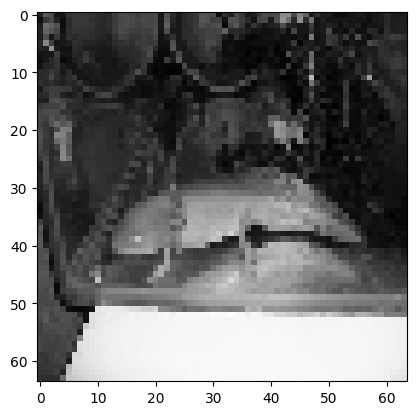

axolotl


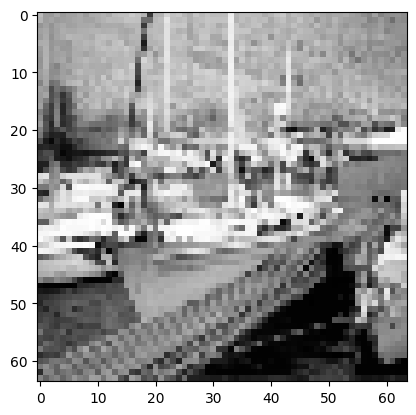

dock


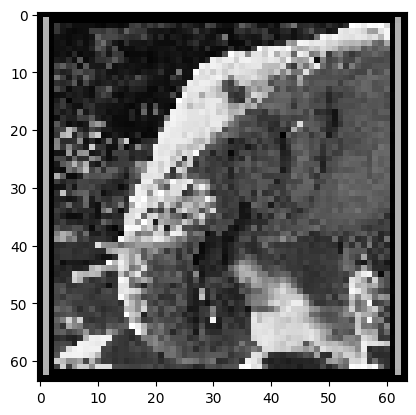

African_elephant


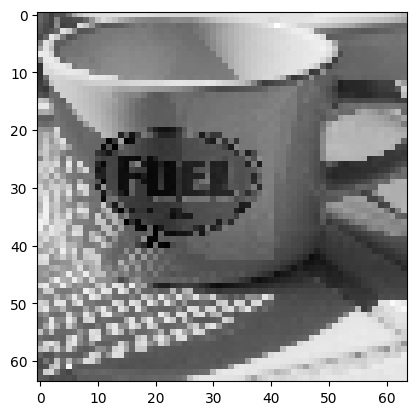

coffee_mug


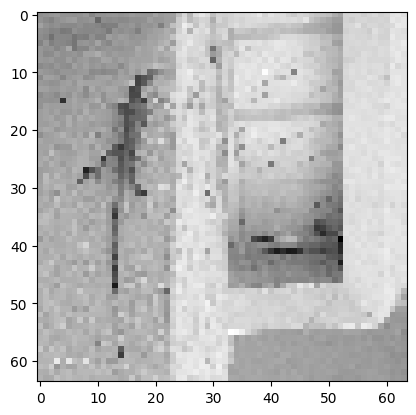

green_lizard


In [5]:
view_train_images(train_images, train_labels)

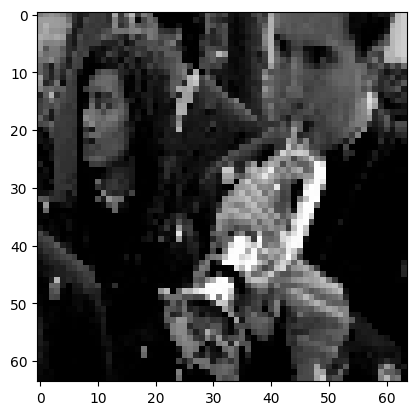

cornet


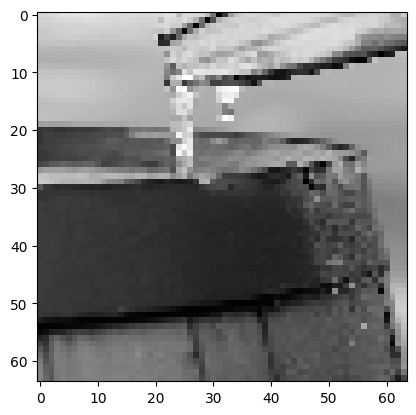

rain_barrel


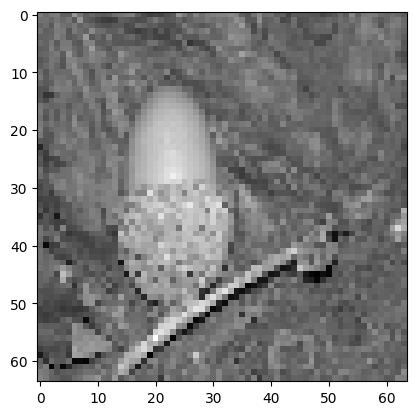

acorn


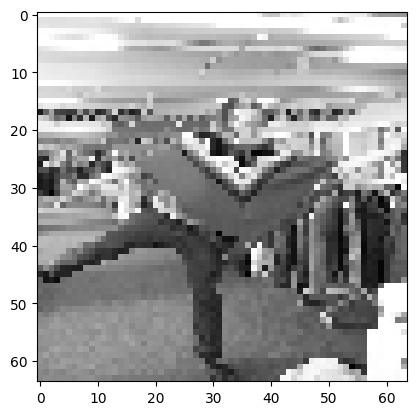

poncho


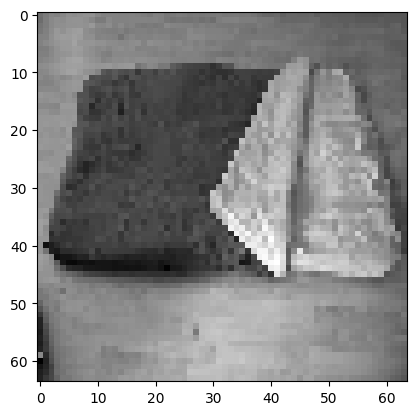

sleeping_bag


In [6]:
view_train_images(val_images, val_labels)

In [7]:
# prepare training data
X_train = np.array(train_images)
X_train = np.repeat(X_train, 3, -1)

Y_train = [str(s) for s in train_labels]
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_hot = to_categorical(Y_train, num_classes=1000)


In [8]:
# prepare testing data
X_test = np.array(val_images)
X_test = np.repeat(X_test, 3, -1)

Y_test = [str(s) for s in val_labels]
label_encoder = LabelEncoder()
Y_test = label_encoder.fit_transform(Y_test)
Y_test_hot = to_categorical(Y_test, num_classes=1000)


In [9]:
# check data shape
print(Y_train.shape)
print(Y_test.shape)

print(len(np.unique(Y_train)))
print(len(np.unique(Y_test)))

(25000,)
(3750,)
1000
968


# 2) Model Optimization #

## a) Keras Classifier ##

In [18]:
# parameters for tuning
epx = 50
batch_size = 8
RSCV_opts = ['adam', 'rmsprop']
krnl = (3, 3)
in_shape = (224, 224, 3)
RSCV_activation = ['relu', 'tanh', 'sigmoid']
RSCV_node1 = [2, 4, 8, 16, 32]
RSCV_node2 = [2, 4, 8, 16, 32]
RSCV_drop = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
RSCV_bacth = [2, 4, 6, 8, 16, 32, 64, 128]

params_grid = dict(node1 = RSCV_node1,
               node2 = RSCV_node2,
               activations = RSCV_activation,
               optimizers = RSCV_opts,
               batch_size = RSCV_bacth,
               drops = RSCV_drop)

In [19]:
# Keras Classifier needs a model builder function to instantiate a new model for each new grid point
def build_CNN(optimizers, node1, activations, node2, drops):
    CNN = Sequential([
        # first layer
        Conv2D(node1, kernel_size=krnl, activation=activations, input_shape=in_shape),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        # 2nd layer
        Conv2D(node2, kernel_size=krnl, activation=activations),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        # output layer
        GlobalAveragePooling2D(),
        Dense(drops),
        Dense(1000, 'softmax')
    ])
    CNN.compile(optimizers,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # return built model
    return CNN

In [20]:
# build Keras Classifier
RS_cnn = KC(build_fn=build_CNN,
            verbose=1,
            epochs=5,
            batch_size=batch_size)

C:\Users\RoiMinuit\AppData\Local\Temp\ipykernel_20752\1010408690.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  RS_cnn = KC(build_fn=build_CNN,


In [21]:
# establish search space and search
grid_search = RSCV(RS_cnn,
                   param_distributions=params_grid,
                   cv=5,
                   scoring='accuracy',
                   verbose=3)

# execute search with categorical Y, not one-hotted
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(2, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(2, 64, 64, 3)


--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\constant_op.py", line 102, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
tensorflow.python.framework.errors_impl.InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(8, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_15" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(8, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(4, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_22" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(4, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_25" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(4, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_29" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(8, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_32" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_35" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_39" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_42" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(4, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_45" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(4, 64, 64, 3)


--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\wrappers\scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\RoiMinuit\AppData\Local\Temp\__autograph_generated_file82e1iqjs.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\RoiMinuit\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_49" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(16, 64, 64, 3)



## b) Keras Tuner ##

In [10]:
# variables for tuning
activations = ['relu', 'elu']
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path + '/ImgNet_Model.h5', monitor='val_loss', save_best_only=True, save_freq='epoch')

In [11]:
# base model for kt
mixed_precision.set_global_policy('mixed_float16')
def build_KT_CNN(hp):
    layers = [
        # input layer
        Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32),
            input_shape=(64, 64, 3),
            kernel_size=(3, 3),
            activation=hp.Choice('activation', activations)),
            Dropout(hp.Float('drop_rate', 0.01, 0.6))
    ]
    
    # hidden layer(s)
    for l in range(hp.Int('num_layers', 1, 4)):
        layers.append(Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32),
                            kernel_size=(3, 3),
                            activation=hp.Choice('activation', activations)))
    
    # output layer
    layers.append(GlobalAveragePooling2D())
    layers.append(Dropout(hp.Float('drop_rate', 0.01, 0.6)))
    layers.append(Dense(1000, activation=hp.Choice('activation', activations)))
    
    CNN = Sequential(layers)
    lr = hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, sampling='LOG', default=1e-3)
    CNN.compile(optimizer=RMSprop(learning_rate=lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    # return built model
    return CNN

build_KT_CNN(kt.HyperParameters())


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [ ]:
# eastablish search space and search
tuner = kt.RandomSearch(
    hypermodel=build_KT_CNN,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    overwrite=True,
    directory=kt_path,
    project_name='ImgNetOptimization'
)

# search
tuner.search(X_train, Y_train,
             batch_size=8,
             epochs=10,
             validation_data=(X_test, Y_test),
             callbacks=[early_stop, checkpoint])
tuner.results_summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |filters
relu              |relu              |activation
0.090928          |0.090928          |drop_rate
3                 |3                 |num_layers
0.0027561         |0.0027561         |learning_rate

Epoch 1/10


In [ ]:
# view optimized model
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1000)              65000     
                                                        

In [ ]:
K.clear_session()
G.collect()

105